# On inference

This notebook demonstrates doing statistical inference with Bayesian and frequentist interpretations of probability, respectively, and whatever maximum-a-posteriori is  exemplified on an auto-regressive moving average model. We do parameter point-estimation using [NumPyro](https://github.com/pyro-ppl/numpyro) the neural network library [Flax](https://github.com/google/flax), while we do distributional inference using [NumPyro](https://github.com/pyro-ppl/numpyro).

In [1]:
import numpyro

In [2]:
import jax
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import optax
import palettes

from flax import linen as nn
from flax.linen import initializers
from flax.training.train_state import TrainState
from jax import numpy as jnp
from jax import random as jr
from numpyro import distributions as dist
from numpyro.infer import Predictive, NUTS, MCMC, SVI, autoguide, Trace_ELBO
from numpyro.distributions import constraints
from numpyro.optim import Adam

from ramsey.data import sample_from_sine_function
from ramsey.experimental import ARMA, Autoregressive

palettes.set_theme()

## Bayesian inference with NumPyro

We begin using posterior inference with NumPyro, since Ramsey is primarily designed for Bayesian inference. We try inferring the parameters of a sample $D$ of autoregressive model of order $p=3$. In NumPyro, an autoregressive model is defined using Ramsey's `Autoregressive` distribution.

In [3]:
N = 50

def model(y=None):
    loc = numpyro.sample("loc", dist.Normal(0.0, 1.0))
    scale = numpyro.sample("scale", dist.HalfNormal(.05))
    ar_coefficients = numpyro.sample("ar_coefficients", dist.Normal(jnp.zeros(3), 1.0))
    numpyro.sample("y", Autoregressive(loc, ar_coefficients, scale, length=N), obs=y)

Take a sample from the prior predictive.

In [4]:
D = Predictive(model, num_samples=1)(rng_key=jr.PRNGKey(2))
D

{'ar_coefficients': Array([[-0.86127895,  0.466094  ,  0.9016245 ]], dtype=float32),
 'loc': Array([-0.16715223], dtype=float32),
 'scale': Array([0.01508139], dtype=float32),
 'y': Array([[-0.15551323, -0.01358793, -0.24605992, -0.10313629, -0.23063725,
         -0.22887355, -0.16606463, -0.33090195, -0.18326025, -0.32700333,
         -0.2943635 , -0.19649543, -0.43370035, -0.15652072, -0.4279162 ,
         -0.256151  , -0.28702515, -0.41836652, -0.20151451, -0.46012908,
         -0.2453366 , -0.33736247, -0.40694   , -0.18276861, -0.5089163 ,
         -0.18289708, -0.38793728, -0.39091808, -0.19186142, -0.51945406,
         -0.13746314, -0.44446993, -0.29581243, -0.2415307 , -0.47141978,
         -0.13167189, -0.48228186, -0.2177226 , -0.30532214, -0.43909886,
         -0.13634376, -0.55494696, -0.15873693, -0.39723483, -0.39497587,
         -0.18413943, -0.5604397 , -0.12821122, -0.45616594, -0.3354902 ]],      dtype=float32)}

Do inference using Markov chain Monte Carlo on $4$ chains.

In [5]:
y = D["y"].flatten()

In [6]:
mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=2000, num_chains=4)
mcmc.run(jr.PRNGKey(1), y=y)

/var/folders/w8/7mc8k9m916qgh982xqxfgsr00000gn/T/ipykernel_42055/1556554331.py:1: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=2000, num_chains=4)
sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:00<00:00, 9891.01it/s, 7 steps of size 1.86e-01. acc. prob=0.92]


In [7]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
ar_coefficients[0]     -0.85      0.02     -0.85     -0.88     -0.81   3941.72      1.00
ar_coefficients[1]      0.46      0.02      0.46      0.43      0.49   4398.85      1.00
ar_coefficients[2]      0.88      0.02      0.88      0.85      0.92   4851.76      1.00
               loc     -0.17      0.01     -0.17     -0.18     -0.15   3865.61      1.00
             scale      0.02      0.00      0.02      0.01      0.02   4236.85      1.00

Number of divergences: 0


The posterior means are prety close to the true values. Let's simulate some data from the posterior predictive.

In [9]:
y_hats = []
for i in range(1000):
    locs = mcmc.get_samples()['loc'][i]
    scale = mcmc.get_samples()['scale'][i]
    coeffs =  mcmc.get_samples()['ar_coefficients'][i]
    ar = Autoregressive(locs, coeffs, scale, length=N)
    y_hat = ar.sample(jr.PRNGKey(i), initial_state=y[0])
    y_hats.append(y_hat)
y_hats = np.vstack(y_hats)
y_hat_cis = jnp.quantile(y_hats, q=jnp.array([0.05, 0.95]), axis=0)

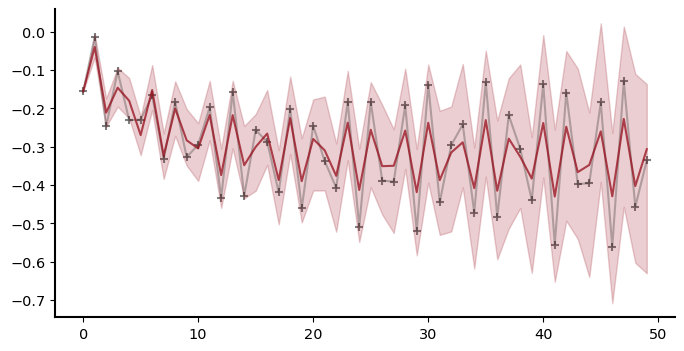

In [10]:
_, ax = plt.subplots(figsize=(8, 4))
ax.scatter(np.arange(len(y)), y, color="black", marker="+", alpha=0.5)
ax.plot(np.arange(len(y)), y, color="black", alpha=0.25)
ax.plot(ar.mean(initial_state=y[0]), color="#960C1A", alpha=0.75)
ax.fill_between(
    np.arange(len(y)),
    y_hat_cis[0],
    y_hat_cis[1],
    color="#960C1A",
    alpha=0.2,
)
plt.show()

## Maximum likelihood inference with NumPyro

Since NumPyro supports maximum likelihood estimation (MLE) which we evaluate next. The model is almost the sample, we merely have to replace the sampling statements with parameter statements.

In [11]:
def model(y=None):
    loc = numpyro.param("loc", 0.0)
    scale = numpyro.param("scale", 1.0, constraints=constraints.positive)
    ar_coefficients = numpyro.param("ar_coefficients", jnp.array([-1.0, 0.0, 1.0]))
    numpyro.sample("y", Autoregressive(loc, ar_coefficients, scale, length=N), obs=y)

Since NumPyro only offers an `MCMC` and an `SVI` class, to do MLE we construct an empty guide and then use "stochastic variational inference", even though we don't do variational inference.

In [12]:
def guide(y=None):
    pass

In [13]:
svi = SVI(model, guide, optim=Adam(0.01), loss=Trace_ELBO())
svi_res = svi.run(jr.PRNGKey(1), y=y, num_steps=1000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5462.66it/s, init loss: 48.4705, avg. loss [951-1000]: -136.4434]


Let's have a look at the parameter estimates.

In [14]:
svi_res.params

{'ar_coefficients': Array([-0.8472309 ,  0.45917058,  0.88509995], dtype=float32),
 'loc': Array(-0.1682046, dtype=float32),
 'scale': Array(0.01579903, dtype=float32)}

These look also okay. Let's again make a probabilistic prediction.

In [15]:
ar = Autoregressive(svi_res.params['loc'], svi_res.params['ar_coefficients'], svi_res.params['scale'], length=N)
samples = jnp.vstack([ar.sample(jr.PRNGKey(i), initial_state=y[0]) for i in range(1000)])
y_hat_cis = jnp.quantile(samples, q=jnp.array([0.05, 0.95]), axis=0)

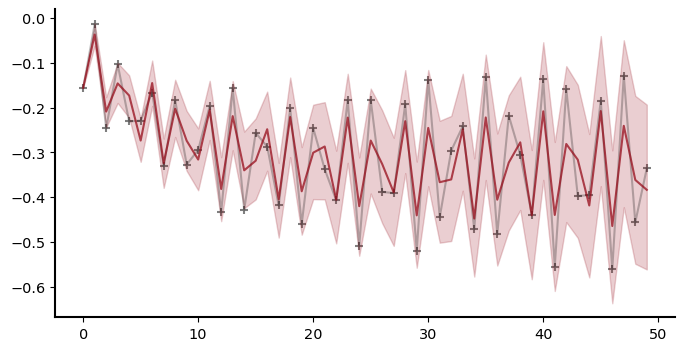

In [16]:
_, ax = plt.subplots(figsize=(8, 4))
ax.scatter(np.arange(len(y)), y, color="black", marker="+", alpha=0.5)
ax.plot(np.arange(len(y)), y, color="black", alpha=0.25)
ax.plot(ar.mean(initial_state=y[0]), color="#960C1A", alpha=0.75)
ax.fill_between(
    np.arange(len(y)),
    y_hat_cis[0],
    y_hat_cis[1],
    color="#960C1A",
    alpha=0.2,
)
plt.show()

## MAP with NumPyro

We can also do maximum-a-posteriori estimation using NumPyro since it is somewhat in the middle between MLE and full Bayesian inference. To do this, we first rewrite the model again in its original formulation, i.e., with sampling statements for all parameters.

In [17]:
def model(y=None):
    loc = numpyro.sample("loc", dist.Normal(0.0, 1.0))
    scale = numpyro.sample("scale", dist.HalfNormal(1.0))
    ar_coefficients = numpyro.sample("ar_coefficients", dist.Normal(jnp.zeros(3), 1.0))
    numpyro.sample("y", Autoregressive(loc, ar_coefficients, scale, length=10), obs=y)

We then construct a guide that puts all mass on one value and maximize it.

In [18]:
guide = autoguide.AutoDelta(model)

In [19]:
svi = SVI(model, guide, optim=Adam(0.01), loss=Trace_ELBO())
svi_res = svi.run(jr.PRNGKey(1), y=y, num_steps=1000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 5337.65it/s, init loss: 150.2576, avg. loss [951-1000]: -131.6718]


In [20]:
svi_res.params

{'ar_coefficients_auto_loc': Array([-0.8466711 ,  0.45913243,  0.8845633 ], dtype=float32),
 'loc_auto_loc': Array(-0.1681924, dtype=float32),
 'scale_auto_loc': Array(0.01579957, dtype=float32)}

Interestingly the coefficients when we do MAP-inference are signifnicantly closer thanthe MLE or fully Bayesian inferences. Since we are doing "point" variational inference, we can treat the guide - which is a delta distribution -  as a posterior distribution and sample from the "posterior predictive".

In [21]:
y_hats = []
for i in range(1000):
    post = guide.sample_posterior(jr.PRNGKey(i), svi_res.params)
    locs = post['loc']
    scale = post['scale']
    coeffs =  post['ar_coefficients']
    ar = Autoregressive(locs, coeffs, scale, length=N)
    y_hat = ar.sample(jr.PRNGKey(i), initial_state=y[0])
    y_hats.append(y_hat)
y_hats = np.vstack(y_hats)
y_hat_cis = jnp.quantile(samples, q=jnp.array([0.05, 0.95]), axis=0)

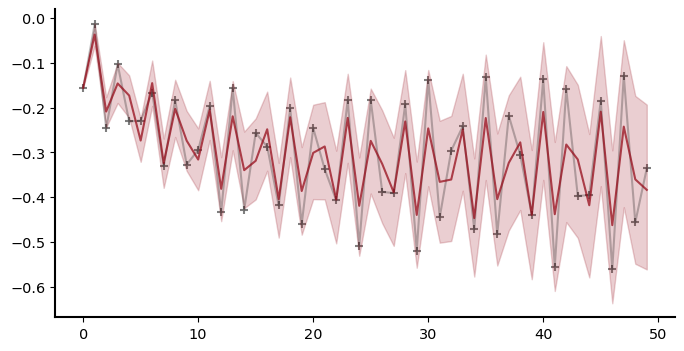

In [22]:
_, ax = plt.subplots(figsize=(8, 4))
ax.scatter(np.arange(len(y)), y, color="black", marker="+", alpha=0.5)
ax.plot(np.arange(len(y)), y, color="black", alpha=0.25)
ax.plot(ar.mean(initial_state=y[0]), color="#960C1A", alpha=0.75)
ax.fill_between(
    np.arange(len(y)),
    y_hat_cis[0],
    y_hat_cis[1],
    color="#960C1A",
    alpha=0.2,
)
plt.show()

## Maximum likelihood inference in Flax

Lastly, we have a look Flax, or any JAX-based neural network, libraries could be used for inference. When using Flax, we first need to wrap the auto-regressive distribution in a Flax `nn.Module`. Since we want to both sample and compute the probabiltiy of a data point, we need to have at least these two methods.

In [23]:
class ARModel(nn.Module):
    order: int
    
    def setup(self):
        self.loc = self.param("loc", initializers.zeros, (1, 1), jnp.float32)
        self.log_scale = self.param("log_scale", initializers.ones, (1, 1), jnp.float32)
        self.ar_coefficients = self.param("ar_coefficients", initializers.zeros, (self.order, 1), jnp.float32)
        
    def __call__(self, inputs):
        return self.log_prob(inputs)
    
    def _get_distr(self):
        ar = Autoregressive(
            self.loc.flatten(), 
            self.ar_coefficients.flatten(), 
            jnp.exp(self.log_scale.flatten())
        )
        return ar
    
    def log_prob(self, inputs):
        ar = self._get_distr()
        return ar.log_prob(inputs)
    
    def sample(self, initial_state, length, shape=()):
        ar = self._get_distr()
        return ar.sample(self.make_rng("sample"), length, initial_state, shape)

Training is done using a typical Optax train loop. We define a train state for convenience and then optimize the parameters via MLE.

In [24]:
def create_train_state(rng, model, optimizer, **init_data):
    init_key, sample_key = jr.split(rng)
    params = model.init({"sample": sample_key, "params": init_key}, **init_data)
    state = TrainState.create(apply_fn=model.apply, params=params, tx=optimizer)
    return state

def train(seed, y, state, n_iter=1000):
    objectives = np.zeros(n_iter)
    for i in range(n_iter):
        @jax.jit
        def step(rngs, state, **batch):
            current_step = state.step
            rngs = {name: jr.fold_in(rng, current_step) for name, rng in rngs.items()}

            def obj_fn(params):
                obj = state.apply_fn(variables=params, rngs=rngs, **batch)
                return -jnp.sum(obj)

            obj, grads = jax.value_and_grad(obj_fn)(state.params)
            new_state = state.apply_gradients(grads=grads)
            return new_state, obj
        
        sample_rng_key, seed = jr.split(seed)
        state, obj = step({"sample": sample_rng_key}, state, inputs=y)
        objectives[i] = obj
    return state.params, objectives

state = create_train_state(jr.PRNGKey(123), ARModel(3), optax.adam(0.01), inputs=y)
params, objectives = train(jr.PRNGKey(1), y, state, 1000)

Let's have a look at the parameters.

In [31]:
params

{'params': {'ar_coefficients': Array([[-0.8472422 ],
         [ 0.45915937],
         [ 0.8850886 ]], dtype=float32),
  'loc': Array([[-0.16819333]], dtype=float32),
  'log_scale': Array([[-4.146778]], dtype=float32)}}

As before, we can make a forecast using the inferred parametes.

In [25]:
ar = Autoregressive(params["params"]['loc'].flatten(), params["params"]['ar_coefficients'].flatten(), jnp.exp(params["params"]['log_scale'].flatten()), length=N)
samples = jnp.vstack([ar.sample(jr.PRNGKey(i), initial_state=y[0]) for i in range(1000)])
y_hat_cis = jnp.quantile(samples, q=jnp.array([0.05, 0.95]), axis=0)

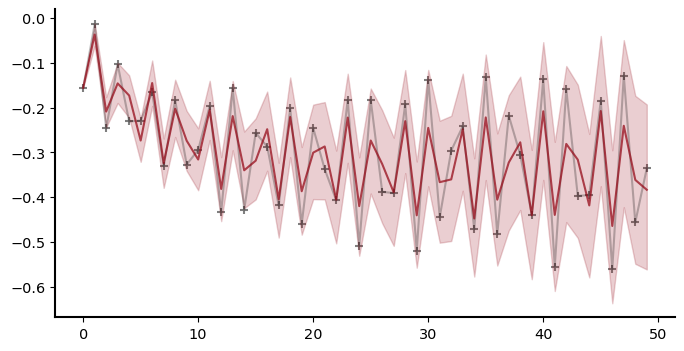

In [26]:
_, ax = plt.subplots(figsize=(8, 4))
ax.scatter(np.arange(len(y)), y, color="black", marker="+", alpha=0.5)
ax.plot(np.arange(len(y)), y, color="black", alpha=0.25)
ax.plot(ar.mean(initial_state=y[0]), color="#960C1A", alpha=0.75)
ax.fill_between(
    np.arange(len(y)),
    y_hat_cis[0],
    y_hat_cis[1],
    color="#960C1A",
    alpha=0.2,
)
plt.show()